In [1]:
from dtw import dtw
import numpy as np
import librosa
import time
import matplotlib.pyplot as plt
%matplotlib inline

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [2]:
import pyaudio
import queue
from typing import Optional

SAMPLE_RATE = 22050
CHANNELS = 1


class StreamProcessor:
    def __init__(self, sample_rate=SAMPLE_RATE, chunk_size=2048):
        self.chunk_size = chunk_size
        self.channels = CHANNELS
        self.sample_rate = sample_rate
        self.format = pyaudio.paFloat32
        self.audio_interface: Optional[pyaudio.PyAudio] = None
        self.audio_stream: Optional[pyaudio.Stream] = None
        self.buffer = queue.Queue()
        self.data = None
        self.is_mic_open = False

    def _process_frame(self, data, frame_count, time_into, status_flag):
        self.buffer.put(data)
        return (data, pyaudio.paContinue)

    def run(self):
        self.audio_interface = pyaudio.PyAudio()
        self.audio_stream = self.audio_interface.open(
            format=self.format,
            channels=self.channels,
            rate=self.sample_rate,
            input=True,
            frames_per_buffer=self.chunk_size,
            stream_callback=self._process_frame,
        )
        self.is_mic_open = True
        self.audio_stream.start_stream()
        print("* Recording in progress....")

    def stop(self):
        if self.is_mic_open:
            self.audio_stream.stop_stream()
            self.audio_stream.close()
            self.is_mic_open = False
            self.audio_interface.terminate()
            print("Recording Stopped.")

* Recording in progress....


/Users/june/.pyenv/versions/miniforge3-4.10.1-5/envs/env/lib/python3.9/site-packages/librosa/core/pitch.py:98: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/Users/june/.pyenv/versions/miniforge3-4.10.1-5/envs/env/lib/python3.9/site-packages/librosa/core/constantq.py:1142: UserWarning: n_fft=512 is too small for input signal of length=256
  D = stft(
/Users/june/.pyenv/versions/miniforge3-4.10.1-5/envs/env/lib/python3.9/site-packages/librosa/core/constantq.py:1142: UserWarning: n_fft=512 is too small for input signal of length=128
  D = stft(
/Users/june/.pyenv/versions/miniforge3-4.10.1-5/envs/env/lib/python3.9/site-packages/librosa/core/constantq.py:1142: UserWarning: n_fft=512 is too small for input signal of length=64
  D = stft(
/Users/june/.pyenv/versions/miniforge3-4.10.1-5/envs/env/lib/python3.9/site-packages/librosa/core/constantq.py:1142: UserWarning: n_fft=512 is too small for input signal of length=32
  D = stft(
/Users/june/.pyenv/

KeyboardInterrupt: 

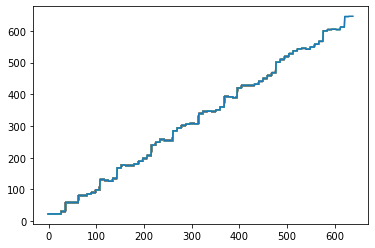

In [3]:
from matplotlib.animation import FuncAnimation

RECORD_SECONDS = 15
SAMPLE_RATE = 22050
CHUNK_SIZE = 2048
HOP_LENGTH = 256

ref_audio, ref_sr = librosa.load('../resources/audio/target/Happy_Birthday_To_You_C_Major.wav')
ref_cens = librosa.feature.chroma_cens(y=ref_audio, sr=ref_sr, hop_length=HOP_LENGTH)
query_start = 0
ref_start = 0
window_size = 16
ref_cens_t = None
query_cens_t = None
index1s = np.array([])
index2s = np.array([])
iteration = 0

sp = StreamProcessor(SAMPLE_RATE, CHUNK_SIZE)
sp.run()

start = time.time()
for _ in range(int(SAMPLE_RATE / CHUNK_SIZE * RECORD_SECONDS)):
    data = sp.buffer.get()
    query_audio = np.frombuffer(data, dtype=np.float32)  # size: 2048 by chunk
    query_cens = librosa.feature.chroma_cens(
        y=query_audio, hop_length=HOP_LENGTH, fmin=librosa.note_to_hz('C2')
    )  # hop_length: 256
    query_cens_t = query_cens.T
    ref_cens_t = ref_cens.T[ref_start : ref_start + 9 + window_size, :]
    alignment = dtw(
        query_cens.T,
        ref_cens_t,
        keep_internals=True,
        open_end=True,
        open_begin=True,
        step_pattern="asymmetric",
    )
    index1s = np.concatenate((index1s, alignment.index1 + query_start))
    index2s = np.concatenate((index2s, alignment.index2 + ref_start))
    plt.plot(index1s, index2s)
    query_start += 9
    ref_start += 9
    iteration += 1

end = time.time()
sp.stop()
duration = end - start
print(f"duration: {duration}")

plt.show()

In [ ]:
from matplotlib.animation import FuncAnimation
from matplotlib import animation, rc

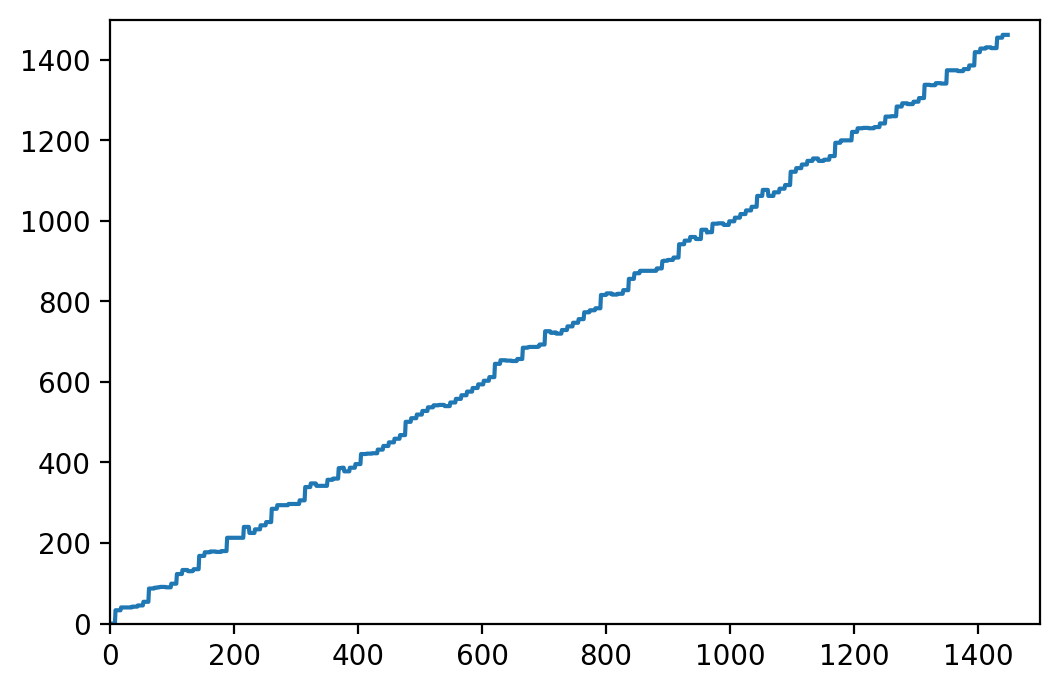

In [ ]:
fig, ax = plt.subplots()
fig.dpi = 200
ax.set_xlim(0, 1500)
ax.set_ylim(0, 1500)
x, y = [], []
line, = plt.plot([], [])

def update(frame):
    first, second = frame
    x.append(first)
    y.append(second)
    line.set_data(x, y)
    return line,

frames = [(first, second) for first, second in zip(index1s, index2s)]
ani = animation.FuncAnimation(fig, update, frames=frames, interval=5)

rc('animation', html='html5')
ani

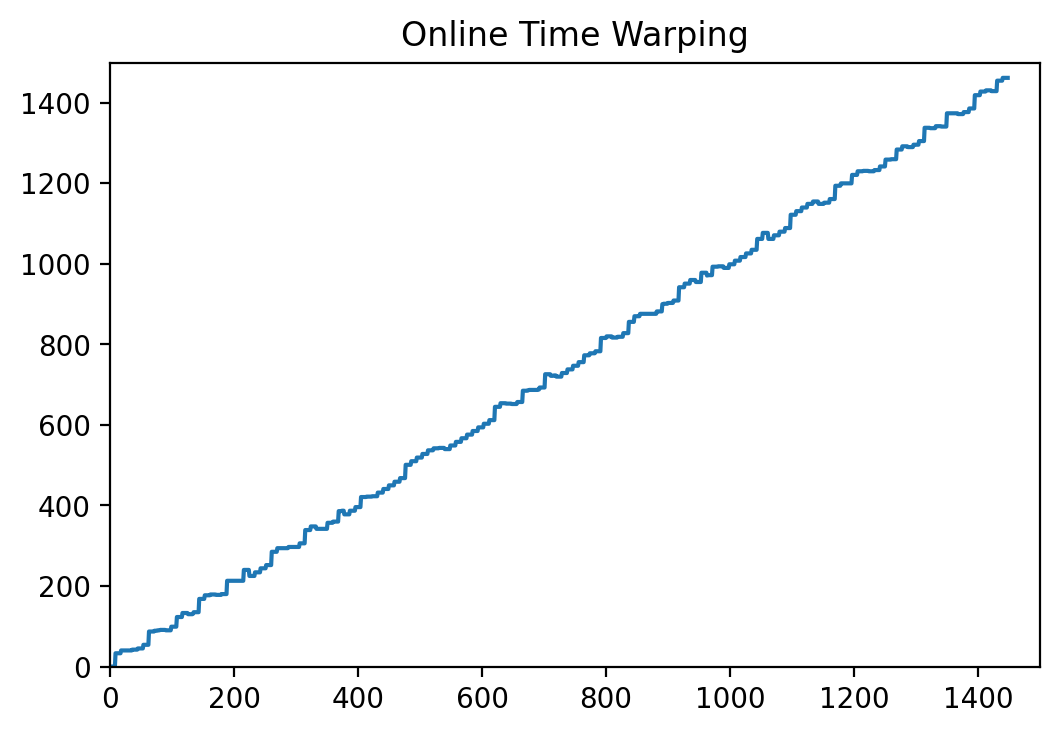

In [ ]:
plt.ion()

fig, ax = plt.subplots()
fig.dpi = 200
ax.set_xlim(0, 1500)
ax.set_ylim(0, 1500)
x, y = [], []
line, = plt.plot(x, y)

plt.title("Online Time Warping")

for index1, index2 in zip(index1s, index2s):
    x.append(index1)
    y.append(index2)
    line.set_xdata(x)
    line.set_ydata(y)
    fig.canvas.draw()
    fig.canvas.flush_events()

# def update(frame):
#     first, second = frame
#     x.append(first)
#     y.append(second)
#     line.set_data(x, y)
#     return line,

# frames = [(first, second) for first, second in zip(index1s, index2s)]
# ani = animation.FuncAnimation(fig, update, frames=frames, interval=5)

rc('animation', html='html5')
plt.show()

In [ ]:
ref_audio.shape, ref_cens.shape

((606464,), (12, 2370))

In [ ]:
import pyaudio
import queue
from typing import Optional

SAMPLE_RATE = 22050
CHANNELS = 1

class StreamProcessor:
    def __init__(self, sample_rate=SAMPLE_RATE, chunk_size=2048):
        self.chunk_size = chunk_size
        self.channels = CHANNELS
        self.sample_rate = sample_rate
        self.format = pyaudio.paFloat32
        self.audio_interface: Optional[pyaudio.PyAudio] = None
        self.audio_stream: Optional[pyaudio.Stream] = None
        self.buffer = queue.Queue()
        self.data = None
        self.is_mic_open = False

    def _process_frame(self, data, frame_count, time_into, status_flag):
        self.buffer.put(data)
        return (data, pyaudio.paContinue)

    def run(self):
        self.audio_interface = pyaudio.PyAudio()
        self.audio_stream = self.audio_interface.open(
            format=self.format,
            channels=self.channels,
            rate=self.sample_rate,
            input=True,
            frames_per_buffer=self.chunk_size,
            stream_callback=self._process_frame,
        )
        self.is_mic_open = True
        self.audio_stream.start_stream()
        print("* Recording in progress....")

    def stop(self):
        if self.is_mic_open:
            self.audio_stream.stop_stream()
            self.audio_stream.close()
            self.is_mic_open = False
            self.audio_interface.terminate()
            print("Recording Stopped.")

* Recording in progress....


/Users/june/.pyenv/versions/miniforge3-4.10.1-5/envs/env/lib/python3.9/site-packages/librosa/core/constantq.py:1142: UserWarning: n_fft=1024 is too small for input signal of length=512
  D = stft(
/Users/june/.pyenv/versions/miniforge3-4.10.1-5/envs/env/lib/python3.9/site-packages/librosa/core/constantq.py:1142: UserWarning: n_fft=1024 is too small for input signal of length=256
  D = stft(
/Users/june/.pyenv/versions/miniforge3-4.10.1-5/envs/env/lib/python3.9/site-packages/librosa/core/constantq.py:1142: UserWarning: n_fft=1024 is too small for input signal of length=128
  D = stft(
/Users/june/.pyenv/versions/miniforge3-4.10.1-5/envs/env/lib/python3.9/site-packages/librosa/core/pitch.py:98: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


duration: 27.082322120666504
Recording Stopped.


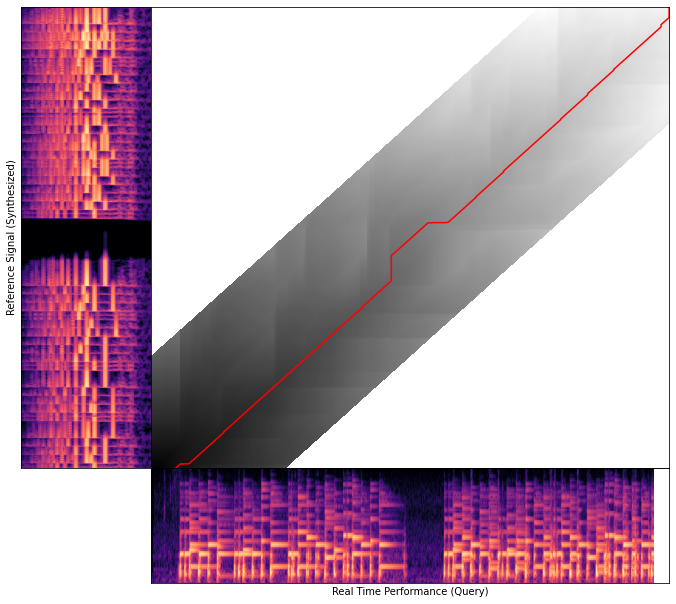

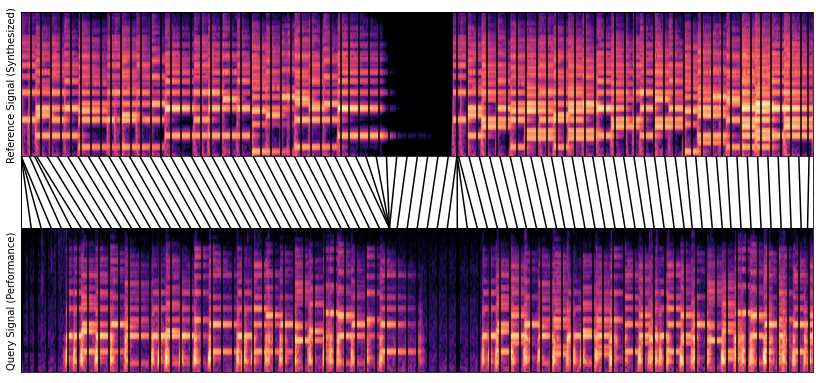

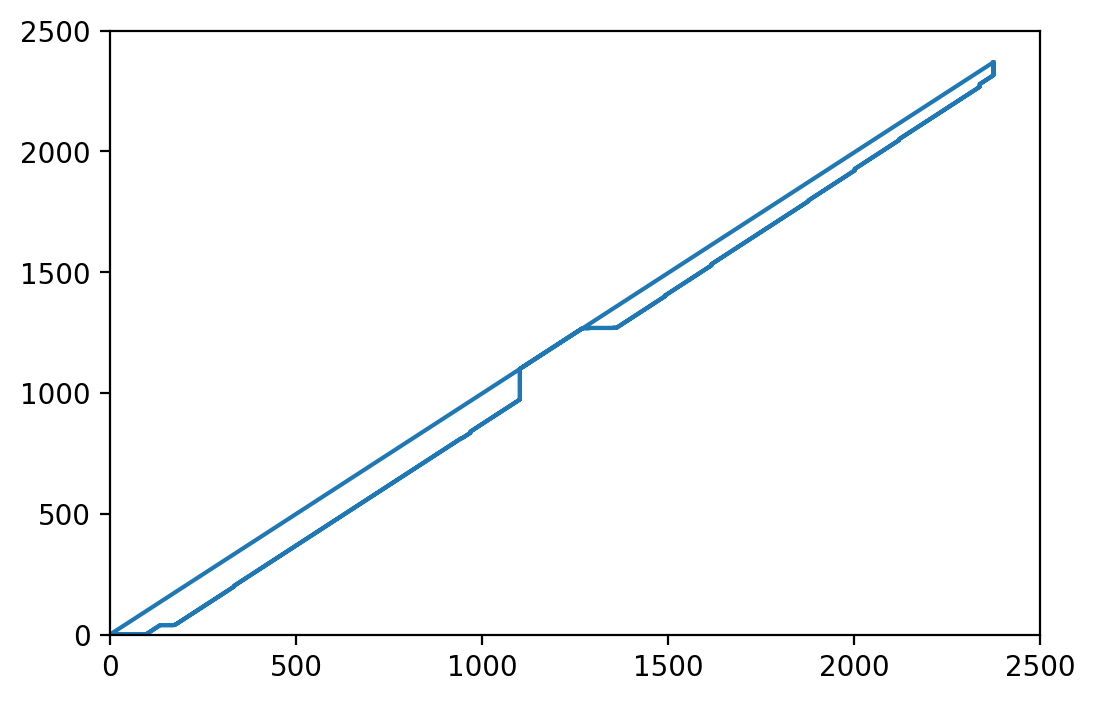

In [ ]:
import time
from enum import IntEnum

import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import animation, rc


class Direction(IntEnum):
    REF = 1
    QUERY = 2
    BOTH = REF | QUERY


import queue
from typing import Optional

import pyaudio

SAMPLE_RATE = 22050
CHANNELS = 1
RECORD_SECONDS = 15
SAMPLE_RATE = 22050
CHUNK_SIZE = 2048
HOP_LENGTH = 256


class OnlineDTW:
    def __init__(self, sp, ref_cens, window_size, max_run_count=30):
        self.sp = sp
        self.ref_cens = ref_cens  # (12, M)
        self.window_size = window_size
        self.max_run_count = max_run_count
        self.query_pointer = 0
        self.ref_pointer = 0
        self.time_length = 0
        self.distance = 0
        self.run_count = 0
        self.previous_direction = None
        self.current_query_cens = None  # (12, N)
        self.query_cens = None  # (12, n)
        self.query_audio = np.array([])
        self.index1s = np.array([])
        self.index2s = np.array([])
        self.warping_path = None
        self.cost_matrix = None
        self.iteration = 0

    def update_path_cost(self, ref_pointer, query_pointer):
        # from librosa
        D, wp = librosa.sequence.dtw(
            X=self.ref_cens[:, :ref_pointer],
            Y=self.query_cens[:, :query_pointer],
            global_constraints=True,
        )
        self.cost_matrix = D
        self.warping_path = wp

    def select_next_direction(self):
        if self.run_count > self.max_run_count:
            if self.previous_direction == Direction.REF:
                time.sleep(0.5)
                next_direction = Direction.QUERY
            else:
                next_direction = Direction.REF

        last_ref_path, last_query_path = self.warping_path[0]
        if (
            last_ref_path + 1 == self.ref_pointer
            and last_query_path + 1 == self.query_pointer
        ):
            next_direction = Direction.BOTH
        elif last_ref_path < last_query_path:
            next_direction = Direction.QUERY
        elif last_ref_path == last_query_path:
            next_direction = Direction.BOTH
        else:
            next_direction = Direction.REF

        return next_direction

    def get_new_input(self):
        data_block = b"".join([sp.buffer.get() for _ in range(self.window_size)])
        query_audio = np.frombuffer(
            data_block, dtype=np.float32
        )  # length: window_size * 2048
        self.query_audio = np.concatenate((self.query_audio, query_audio))
        query_cens = librosa.feature.chroma_cens(
            y=query_audio,
            hop_length=HOP_LENGTH,
        )  # hop_length: 256
        self.current_query_cens = query_cens
        self.time_length = self.current_query_cens.shape[1]

        if self.query_cens is None:
            self.query_cens = self.current_query_cens
        else:
            self.query_cens = np.concatenate(
                (self.query_cens, self.current_query_cens), axis=1
            )

    def run(self):
        self.sp.run()  # mic ON
        self.query_pointer += int(CHUNK_SIZE / HOP_LENGTH * self.window_size) + 1
        self.ref_pointer += int(CHUNK_SIZE / HOP_LENGTH * self.window_size) + 1
        start_time = time.time()
        self.get_new_input()
        self.update_path_cost(self.ref_pointer, self.query_pointer)

        while self.ref_pointer < self.ref_cens.shape[1]:
            if self.select_next_direction() is not Direction.REF:
                self.query_pointer += self.time_length
                self.get_new_input()
                self.update_path_cost(self.ref_pointer, self.query_pointer)
                # for k in range(
                #     max(1, self.ref_pointer - self.window_size + 1), self.ref_pointer
                # ):
                #     self.update_path_cost(self.query_pointer, k)

            if self.select_next_direction() is not Direction.QUERY:
                self.ref_pointer += self.time_length
                self.update_path_cost(self.ref_pointer, self.query_pointer)
                # for k in range(
                #     max(1, self.query_pointer - self.window_size + 1),
                #     self.query_pointer,
                # ):
                #     self.update_path_cost(k, self.ref_pointer)

            if self.select_next_direction() == self.previous_direction:
                self.run_count += 1
            else:
                self.run_count = 1

            if self.select_next_direction() is not Direction.BOTH:
                self.previous_direction = self.select_next_direction()
            self.iteration += 1

            if self.iteration == 16:
                pass

        end_time = time.time()
        print(f"duration: {end_time - start_time}")
        self.sp.stop()


ref_audio, ref_sr = librosa.load(
    "../resources/audio/target/Happy_Birthday_To_You_C_Major.wav"
)
ref_cens = librosa.feature.chroma_cens(y=ref_audio, sr=ref_sr, hop_length=HOP_LENGTH)
sp = StreamProcessor(SAMPLE_RATE, CHUNK_SIZE)
odtw = OnlineDTW(sp, ref_cens, window_size=4)
odtw.run()


# fig, ax = plt.subplots(nrows=2, sharex=True)
# img = librosa.display.specshow(odtw.cost_matrix, x_axis="frames", y_axis="frames", ax=ax[0])
# ax[0].set(title='DTW cost', xlabel="Real Time Audio", ylabel="Reference")
# ax[0].plot(odtw.warping_path[:, -1], odtw.warping_path[:, 0], label="Optimal path", color="y")
# ax[0].legend()
# fig.colorbar(img, ax=ax[0])
# ax[1].plot(odtw.cost_matrix[-1, :] / odtw.warping_path.shape[0])
# ax[1].set(xlim=[0, odtw.query_cens.shape[1]], ylim=[0, 2], title="Matching cost function")
# # flipped_path = np.flip(odtw.warping_path)
# # plt.plot(flipped_path[:, 0], flipped_path[:, 1])

# plt.show()
query_cqt = librosa.cqt(y=odtw.query_audio, sr=SAMPLE_RATE, hop_length=HOP_LENGTH)
query_cqt_mag = librosa.amplitude_to_db(np.abs(query_cqt))
ref_cqt = librosa.cqt(y=ref_audio, sr=SAMPLE_RATE, hop_length=HOP_LENGTH)
ref_cqt_mag = librosa.amplitude_to_db(np.abs(ref_cqt))

plt.figure(figsize=(9, 8))

# Bottom right plot.
ax1 = plt.axes([0.2, 0, 0.8, 0.20])
ax1.imshow(
    query_cqt_mag,
    origin="lower",
    aspect="auto",
    cmap="magma",
)
ax1.set_xlabel("Real Time Performance (Query)")
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_ylim(20)

# Top left plot.
ax2 = plt.axes([0, 0.2, 0.20, 0.8])
ax2.imshow(
    ref_cqt_mag.T[:, ::-1],
    origin="lower",
    aspect="auto",
    cmap="magma",
)
ax2.set_ylabel("Reference Signal (Synthesized)")
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_ylim(20)

# Top right plot.
ax3 = plt.axes([0.2, 0.2, 0.8, 0.8], sharex=ax1, sharey=ax2)
ax3.imshow(
    odtw.cost_matrix,
    aspect="auto",
    origin="lower",
    interpolation="nearest",
    cmap="gray",
)
ax3.set_xticks([])
ax3.set_yticks([])

# Path.
ax3.plot(np.flip(odtw.warping_path)[:, 0], np.flip(odtw.warping_path)[:, 1], "r")
plt.show()


### SECOND PLOT

plt.figure(figsize=(11, 5))

# Top plot.
ax1 = plt.axes([0, 0.60, 1, 0.40])
ax1.imshow(ref_cqt_mag, origin="lower", aspect="auto", cmap="magma")
ax1.set_ylabel("Reference Signal (Synthesized)")
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_ylim(20)
ax1.set_xlim(0, ref_cqt.shape[1])

# Bottom plot.
ax2 = plt.axes([0, 0, 1, 0.40])
ax2.imshow(query_cqt_mag, origin="lower", aspect="auto", cmap="magma")
ax2.set_ylabel("Query Signal (Performance)")
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_ylim(20)
ax2.set_xlim(0, query_cqt.shape[1])

# Middle plot.
line_color = "k"
step = 30
n1 = float(ref_cqt.shape[1])
n2 = float(query_cqt.shape[1])
ax3 = plt.axes([0, 0.40, 1, 0.20])
for ref, query in zip(
    np.flip(odtw.warping_path)[:, 0][::step], np.flip(odtw.warping_path)[:, 1][::step]
):
    ax3.plot((query / n2, ref / n1), (1, -1), color=line_color)
    ax3.set_xlim(0, 1)
    ax3.set_ylim(-1, 1)

# Path markers on top and bottom plot.
y1_min, y1_max = ax1.get_ylim()
y2_min, y2_max = ax2.get_ylim()

ax1.vlines(np.flip(odtw.warping_path)[:, 0][::step], y1_min, y1_max, color=line_color)
ax2.vlines(np.flip(odtw.warping_path)[:, 1][::step], y2_min, y2_max, color=line_color)
ax3.set_xticks([])
ax3.set_yticks([])

plt.show()

### THIRD ANIMATION

fig, ax = plt.subplots()
fig.dpi = 200
ax.set_xlim(0, 2500)
ax.set_ylim(0, 2500)
x, y = [], []
line, = plt.plot([], [])

def update(frame):
    first, second = frame
    x.append(first)
    y.append(second)
    line.set_data(x, y)
    return line,

frames = np.flip(odtw.warping_path)
ani = animation.FuncAnimation(fig, update, frames=frames, interval=0.1)
ani.save('exAnimation.gif', fps=600, dpi=200)

rc('animation', html='html5')
ani

* Recording in progress....


/Users/june/.pyenv/versions/miniforge3-4.10.1-5/envs/env/lib/python3.9/site-packages/librosa/core/constantq.py:1142: UserWarning: n_fft=1024 is too small for input signal of length=512
  D = stft(
/Users/june/.pyenv/versions/miniforge3-4.10.1-5/envs/env/lib/python3.9/site-packages/librosa/core/constantq.py:1142: UserWarning: n_fft=1024 is too small for input signal of length=256
  D = stft(
/Users/june/.pyenv/versions/miniforge3-4.10.1-5/envs/env/lib/python3.9/site-packages/librosa/core/constantq.py:1142: UserWarning: n_fft=1024 is too small for input signal of length=128
  D = stft(


duration: 27.080366134643555
Recording Stopped.


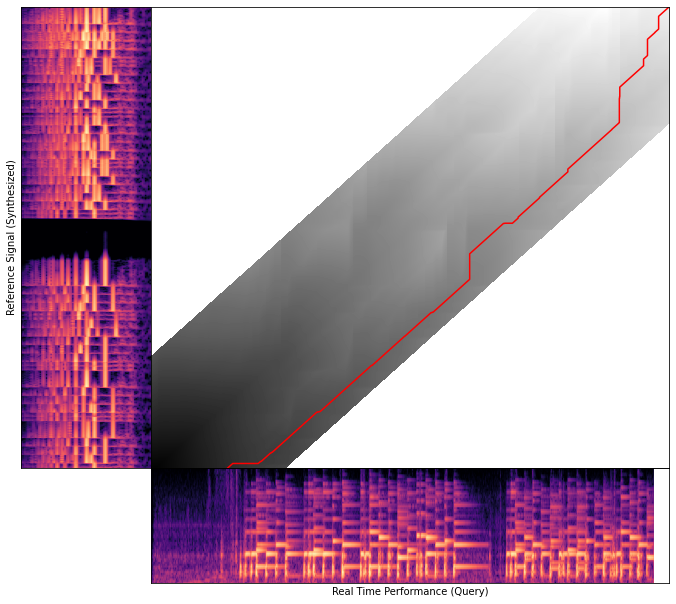

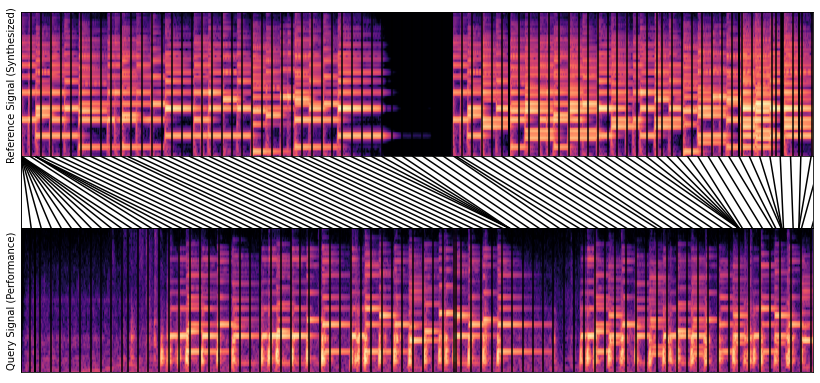

In [ ]:
import time
from enum import IntEnum

import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import animation, rc


class Direction(IntEnum):
    REF = 1
    QUERY = 2
    BOTH = REF | QUERY


import queue
from typing import Optional

import pyaudio

SAMPLE_RATE = 22050
CHANNELS = 1
RECORD_SECONDS = 15
SAMPLE_RATE = 22050
CHUNK_SIZE = 2048
HOP_LENGTH = 256


class OnlineDTW:
    def __init__(self, sp, ref_cens, window_size, max_run_count=30):
        self.sp = sp
        self.ref_cens = ref_cens  # (12, M)
        self.window_size = window_size
        self.max_run_count = max_run_count
        self.query_pointer = 0
        self.ref_pointer = 0
        self.time_length = 0
        self.distance = 0
        self.run_count = 0
        self.previous_direction = None
        self.current_query_cens = None  # (12, N)
        self.query_cens = None  # (12, n)
        self.query_audio = np.array([])
        self.index1s = np.array([])
        self.index2s = np.array([])
        self.warping_path = None
        self.cost_matrix = None
        self.iteration = 0

    def update_path_cost(self, ref_pointer, query_pointer):
        # from librosa
        D, wp = librosa.sequence.dtw(
            X=self.ref_cens[:, :ref_pointer],
            Y=self.query_cens[:, :query_pointer],
            global_constraints=True,
        )
        self.cost_matrix = D
        self.warping_path = wp

    def select_next_direction(self):
        if self.run_count > self.max_run_count:
            if self.previous_direction == Direction.REF:
                time.sleep(0.5)
                next_direction = Direction.QUERY
            else:
                next_direction = Direction.REF

        last_ref_path, last_query_path = self.warping_path[0]
        if (
            last_ref_path + 1 == self.ref_pointer
            and last_query_path + 1 == self.query_pointer
        ):
            next_direction = Direction.BOTH
        elif last_ref_path < last_query_path:
            next_direction = Direction.QUERY
        elif last_ref_path == last_query_path:
            next_direction = Direction.BOTH
        else:
            next_direction = Direction.REF

        return next_direction

    def get_new_input(self):
        data_block = b"".join([self.sp.buffer.get() for _ in range(self.window_size)])
        query_audio = np.frombuffer(
            data_block, dtype=np.float32
        )  # length: window_size * 2048
        self.query_audio = np.concatenate((self.query_audio, query_audio))
        query_cens = librosa.feature.chroma_cens(
            y=query_audio,
            hop_length=HOP_LENGTH,
        )  # hop_length: 256
        self.current_query_cens = query_cens
        self.time_length = self.current_query_cens.shape[1]

        if self.query_cens is None:
            self.query_cens = self.current_query_cens
        else:
            self.query_cens = np.concatenate(
                (self.query_cens, self.current_query_cens), axis=1
            )

    def run(self):
        self.sp.run()  # mic ON
        self.query_pointer += int(CHUNK_SIZE / HOP_LENGTH * self.window_size) + 1
        self.ref_pointer += int(CHUNK_SIZE / HOP_LENGTH * self.window_size) + 1
        start_time = time.time()
        self.get_new_input()
        self.update_path_cost(self.ref_pointer, self.query_pointer)

        while self.ref_pointer < self.ref_cens.shape[1]:
            if self.select_next_direction() is not Direction.REF:
                self.query_pointer += self.time_length
                self.get_new_input()
                self.update_path_cost(self.ref_pointer, self.query_pointer)

            if self.select_next_direction() is not Direction.QUERY:
                self.ref_pointer += self.time_length
                self.update_path_cost(self.ref_pointer, self.query_pointer)

            if self.select_next_direction() == self.previous_direction:
                self.run_count += 1
            else:
                self.run_count = 1

            if self.select_next_direction() is not Direction.BOTH:
                self.previous_direction = self.select_next_direction()
            self.iteration += 1

        end_time = time.time()
        print(f"duration: {end_time - start_time}")
        self.sp.stop()


ref_audio, ref_sr = librosa.load(
    "../resources/audio/target/Happy_Birthday_To_You_C_Major.wav"
)
ref_cens = librosa.feature.chroma_cens(y=ref_audio, sr=ref_sr, hop_length=HOP_LENGTH)
sp = StreamProcessor(SAMPLE_RATE, CHUNK_SIZE)
odtw = OnlineDTW(sp, ref_cens, window_size=4)
odtw.run()

query_cqt = librosa.cqt(y=odtw.query_audio, sr=SAMPLE_RATE, hop_length=HOP_LENGTH)
query_cqt_mag = librosa.amplitude_to_db(np.abs(query_cqt))
ref_cqt = librosa.cqt(y=ref_audio, sr=SAMPLE_RATE, hop_length=HOP_LENGTH)
ref_cqt_mag = librosa.amplitude_to_db(np.abs(ref_cqt))

plt.figure(figsize=(9, 8))

# Bottom right plot.
ax1 = plt.axes([0.2, 0, 0.8, 0.20])
ax1.imshow(
    query_cqt_mag,
    origin="lower",
    aspect="auto",
    cmap="magma",
)
ax1.set_xlabel("Real Time Performance (Query)")
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_ylim(20)

# Top left plot.
ax2 = plt.axes([0, 0.2, 0.20, 0.8])
ax2.imshow(
    ref_cqt_mag.T[:, ::-1],
    origin="lower",
    aspect="auto",
    cmap="magma",
)
ax2.set_ylabel("Reference Signal (Synthesized)")
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_ylim(20)

# Top right plot.
ax3 = plt.axes([0.2, 0.2, 0.8, 0.8], sharex=ax1, sharey=ax2)
ax3.imshow(
    odtw.cost_matrix,
    aspect="auto",
    origin="lower",
    interpolation="nearest",
    cmap="gray",
)
ax3.set_xticks([])
ax3.set_yticks([])

# Path.
ax3.plot(np.flip(odtw.warping_path)[:, 0], np.flip(odtw.warping_path)[:, 1], "r")
plt.show()


### SECOND PLOT

plt.figure(figsize=(11, 5))

# Top plot.
ax1 = plt.axes([0, 0.60, 1, 0.40])
ax1.imshow(ref_cqt_mag, origin="lower", aspect="auto", cmap="magma")
ax1.set_ylabel("Reference Signal (Synthesized)")
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_ylim(20)
ax1.set_xlim(0, ref_cqt.shape[1])

# Bottom plot.
ax2 = plt.axes([0, 0, 1, 0.40])
ax2.imshow(query_cqt_mag, origin="lower", aspect="auto", cmap="magma")
ax2.set_ylabel("Query Signal (Performance)")
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_ylim(20)
ax2.set_xlim(0, query_cqt.shape[1])

# Middle plot.
line_color = "k"
step = 30
n1 = float(ref_cqt.shape[1])
n2 = float(query_cqt.shape[1])
ax3 = plt.axes([0, 0.40, 1, 0.20])
for ref, query in zip(
    np.flip(odtw.warping_path)[:, 0][::step], np.flip(odtw.warping_path)[:, 1][::step]
):
    ax3.plot((query / n2, ref / n1), (1, -1), color=line_color)
    ax3.set_xlim(0, 1)
    ax3.set_ylim(-1, 1)

# Path markers on top and bottom plot.
y1_min, y1_max = ax1.get_ylim()
y2_min, y2_max = ax2.get_ylim()

ax1.vlines(np.flip(odtw.warping_path)[:, 0][::step], y1_min, y1_max, color=line_color)
ax2.vlines(np.flip(odtw.warping_path)[:, 1][::step], y2_min, y2_max, color=line_color)
ax3.set_xticks([])
ax3.set_yticks([])

plt.show()

In [ ]:
odtw.query_cens.shape

(12, 2376)

In [ ]:
path = np.flip(odtw.warping_path)
print(path)

[[   0    0]
 [   1    0]
 [   2    0]
 ...
 [2373 2367]
 [2374 2368]
 [2375 2369]]


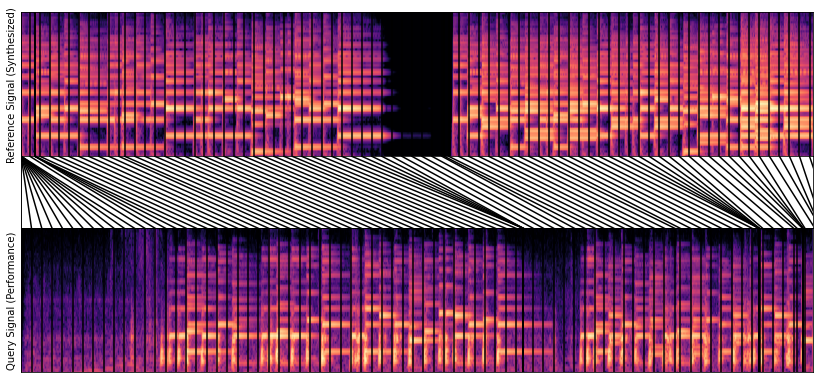

In [ ]:
path = np.flip(odtw.warping_path)

plt.figure(figsize=(11, 5))

# Top plot.
ax1 = plt.axes([0, 0.60, 1, 0.40])
ax1.imshow(ref_cqt_mag, origin="lower", aspect="auto", cmap="magma")
ax1.set_ylabel("Reference Signal (Synthesized)")
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_ylim(20)
ax1.set_xlim(0, ref_cqt.shape[1])

# Bottom plot.
ax2 = plt.axes([0, 0, 1, 0.40])
ax2.imshow(query_cqt_mag, origin="lower", aspect="auto", cmap="magma")
ax2.set_ylabel("Query Signal (Performance)")
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_ylim(20)
ax2.set_xlim(0, query_cqt.shape[1])

# Middle plot.
line_color = "k"
step = 30
n1 = float(ref_cqt.shape[1])
n2 = float(query_cqt.shape[1])
ax3 = plt.axes([0, 0.40, 1, 0.20])
for query, ref in path[::step]:
    ax3.plot((ref / n1, query / n2), (1, -1), color=line_color)
    ax3.set_xlim(0, 1)
    ax3.set_ylim(-1, 1)

# Path markers on top and bottom plot.
y1_min, y1_max = ax1.get_ylim()
y2_min, y2_max = ax2.get_ylim()

ax1.vlines([t[1] for t in path[::step]], y1_min, y1_max, color=line_color)
ax2.vlines([t[0] for t in path[::step]], y2_min, y2_max, color=line_color)
ax3.set_xticks([])
ax3.set_yticks([])

plt.show()